In [ ]:
# Install dependecies
!pip install -q datasets transformers
!pip install accelerate
!pip install -U pip wheel
!pip install ensemble-transformers

ERROR: Operation cancelled by user


In [ ]:
# Load the Gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Run this cell to avoid any error in ensemble-transformer library
# After running it, please restart the kernel
import shutil
import os

src_path = '/content/drive/MyDrive/Resource/config.py'
dst_path = '/usr/local/lib/python3.10/dist-packages/ensemble_transformers'
os.remove(dst_path + '/config.py')
shutil.copy(src_path, dst_path)

In [ ]:
# Dataset labels id
id2label = {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}


In [ ]:
from ensemble_transformers import EnsembleModelForImageClassification
# Load the models
# pre-trained model checkpoint to be used for fine-tuning
model_names = ["ALM-AHME/swinv2-large-patch4-window12to16-192to256-22kto1k-ft-finetuned-Lesion-Classification-HAM10000-AH" ,
               "ALM-AHME/beit-large-patch16-224-finetuned-Lesion-Classification-HAM10000-AH-60-20-20",
               "ALM-AHME/convnextv2-large-1k-224-finetuned-Lesion-Classification-HAM10000-AH-60-20-20"]

ensemble = EnsembleModelForImageClassification.from_multiple_pretrained(*model_names)


In [ ]:
#load libraries
import matplotlib.pyplot as plt
import numpy as np
# Import the image processor compatible with the given model architecture
from transformers import AutoImageProcessor
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import torch
from ensemble_transformers import EnsembleModelForImageClassification
from PIL import Image
import os
import time

In [ ]:
# Load the model to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ensemble.to(device)

In [ ]:
# Majority
img_path = '/content/drive/MyDrive/Skin_Cancer/Augmented-Final/test/'

# Target list is the ground truth labels
target_list = []
# Prediction list is the predicted labels
pred_list = []

# Folder index to store the label id of each folder class
folder_index = 0
# get the start time
start_time = time.time()

for foldername in os.listdir(img_path):
    for filename in os.listdir(img_path + foldername):
        im = Image.open(img_path + foldername + "/" + filename)

        with torch.no_grad():
            logits = ensemble(im).logits
            # print(logits)

        pred_count = []

        for logit in logits:
          predicted_label = logit.to('cpu').argmax(-1).item()
          pred_count.append(predicted_label)
        # Count the number of votes for each model prediction
        final_pred = np.argmax(np.bincount(pred_count))
        # print(final_pred)
        target_list.append(folder_index)
        pred_list.append(final_pred)

        # break
    folder_index += 1

    print("Target: " , target_list)
    print("Predicted: " , pred_list)

end_time = time.time()

elapsed_time = end_time - start_time
print('\nTotal Execution time:', elapsed_time, 'seconds')

Target:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Predicted:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Visualize Results

In [ ]:
#load libraries
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
import warnings

import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

In [ ]:
target_list_copy = target_list
pred_list_copy = pred_list

<Axes: xlabel='Predicted Labels', ylabel='Actual Labels'>

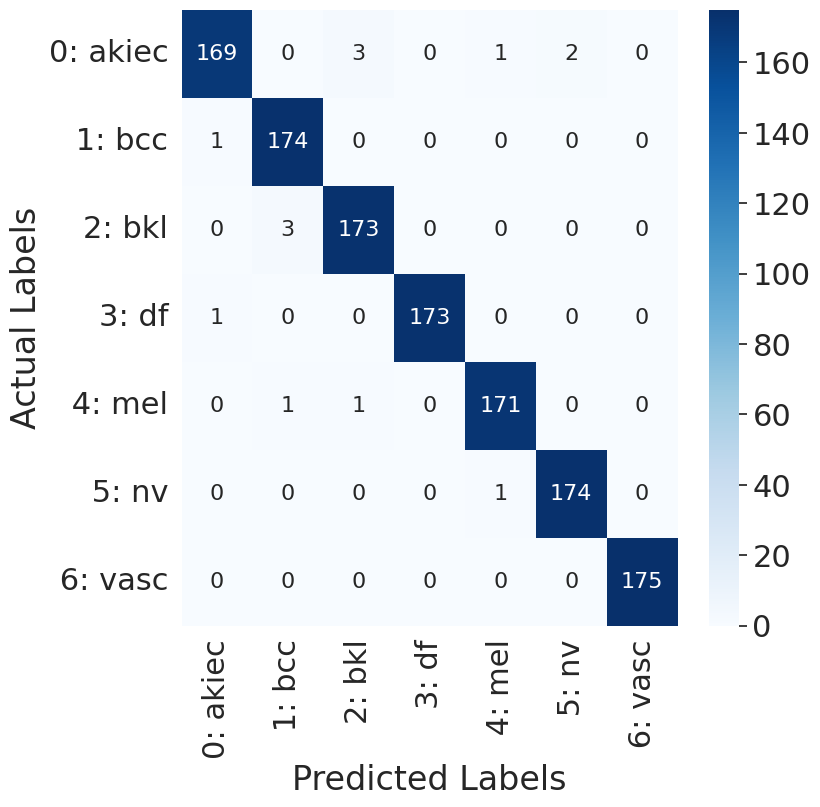

In [ ]:
# test_pred_labels=pred_list_copy.argmax(axis=1)
# Plot Confusion Matrix

data = confusion_matrix(target_list_copy,pred_list_copy,labels=[0,1,2,3,4,5,6])
df_cm = pd.DataFrame(data, columns=['0: akiec',' 1: bcc', '2: bkl','3: df',' 4: mel',' 5: nv',' 6: vasc'], index = ['0: akiec',' 1: bcc', '2: bkl','3: df',' 4: mel',' 5: nv',' 6: vasc'])
df_cm.index.name = 'Actual Labels'
df_cm.columns.name = 'Predicted Labels'
plt.figure(figsize = (8,8))
sn.set(font_scale=2)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')# font size


In [ ]:
# Classification report
print(classification_report(target_list_copy,pred_list_copy))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       175
           1       0.98      0.99      0.99       175
           2       0.98      0.98      0.98       176
           3       1.00      0.99      1.00       174
           4       0.99      0.99      0.99       173
           5       0.99      0.99      0.99       175
           6       1.00      1.00      1.00       175

    accuracy                           0.99      1223
   macro avg       0.99      0.99      0.99      1223
weighted avg       0.99      0.99      0.99      1223



In [ ]:
# compute all scores macro and weighted
def evaluation_summary(desc, predictions, true_labels):
    accuracy = accuracy_score(predictions, true_labels)
    precision = precision_score(predictions, true_labels, average='macro')
    recall = recall_score(predictions, true_labels, average='macro')
    f1 = fbeta_score(predictions, true_labels, beta=1, average='macro')
    weighted_precision = precision_score(predictions, true_labels, average='weighted')
    weighted_recall = recall_score(predictions, true_labels, average='weighted')
    weighted_f1 = fbeta_score(predictions, true_labels, beta=1, average='weighted')
    results = {
            "classifier": [desc],
            "accuracy": [round(accuracy,3)],
            "macro_precision": [round(precision,3)],
            "macro_recall": [round(recall,3)],
            "macro_f1": [round(f1,3)],
            "weighted_precision": [round(weighted_precision,3)],
            "weighted_recall": [round(weighted_recall,3)],
            "weighted_f1": [round(weighted_f1,3)]
            }
    return pd.DataFrame.from_dict(results)

In [ ]:
beit_test_result=evaluation_summary("Ensemble-Transformer-Classification- Test data", pred_list_copy , target_list_copy)

summary_eval = pd.concat([beit_test_result], axis=0)
summary_eval = summary_eval.reset_index(drop=True)
color = (summary_eval.weighted_f1 > 0).map({True: 'background-color: green', False: ''})
summary_eval.style.apply(lambda s: color)

,classifier,accuracy,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1
0,Ensemble-Transformer-Classification- Test data,0.989000,0.989000,0.989000,0.989000,0.989000,0.989000,0.989000
